# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-algq4efh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-algq4efh
  Resolved https://github.com/huggingface/transformers to commit 6dfd561d9cd722dfc09f702355518c6d09b9b4e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.55.0.dev0-py3-none-any.whl size=12195662 sha256=bd471d4069220c6b56803e95beb0b975db43c4e06ffbc42480305994b084d2dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-43qnvc86/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
 

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-08-03 18:55:54.601727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754247354.984120      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754247355.086710      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME = "gpt2"
BATCH_SIZE = 8
MAX_SEQ_LENGTH = 512
IMAGE_SIZE = 224

# Data Split Params
VALID_SIZE = 0.10
TEST_SIZE = 0.10
RANDOM_STATE = 42

In [6]:
def clean_text(text):
    if text is None:
        return ""
    # More comprehensive text cleaning for medical reports
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text

def create_data_manifest(xml_dir, img_dir):
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text = clean_text(findings_node.text if findings_node is not None else "")
            
            # Prepend custom section tokens
            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} {tokenizer.eos_token}"

            if not findings_text and not impression_text:
                continue
            
            image_nodes = root.findall(".//parentImage")
            image_paths = []
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if len(image_paths) > 0:
                manifest.append({
                    'image_paths': image_paths,  # << now a list
                    'report_text': full_report
                })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest



In [7]:
class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']  # This is now a list

        # Process all images for this report
        image_tensors = []
        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image)
            image_tensors.append(image_tensor)

        # Process text
        tokenized_report = self.tokenizer(
            report_text,
            truncation=True,
            max_length=512
        )
        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "images": image_tensors,          # <--- list of tensors
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_paths": image_paths        # <--- list of strings
        }


In [8]:
def custom_collate_fn(batch):
    # images: list of lists of tensors (each inner list is an example's images)
    image_lists = [item['images'] for item in batch]  # shape: (batch_size, num_views, C, H, W)
    image_paths_lists = [item['image_paths'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list = [item['labels'] for item in batch]

    # Pad image lists per batch; if using a SetTransformer fusion, you can stack as-is or pad to max view count within the batch
    max_views = max(len(images) for images in image_lists)
    batch_images = []
    mask = []
    for images in image_lists:
        padded = images + [torch.zeros_like(images[0])] * (max_views - len(images))
        batch_images.append(torch.stack(padded))
        mask.append([1]*len(images) + [0]*(max_views - len(images)))   # Optionally keep a mask

    batch_images = torch.stack(batch_images)  # (batch, max_views, C, H, W)
    view_mask = torch.tensor(mask)            # (batch, max_views)

    # Pad text sequences
    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest',
        return_tensors='pt'
    )
    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids']

    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'images': batch_images,            # (B, max_views, C, H, W)
        'view_mask': view_mask,            # Mask for valid views per study
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels,
        'image_paths': image_paths_lists   # list of lists
    }


In [9]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token  # Keep this line for consistent padding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [01:01<00:00, 64.32it/s]


Data successfully split:
Total samples: 3826
Training set:  3060 samples
Validation set: 383 samples
Test set:      383 samples

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---



You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths'])
Image tensor shape:      torch.Size([8, 4, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 175])
Attention mask shape:    torch.Size([8, 175])
Labels tensor shape:     torch.Size([8, 175])
View mask shape:         tensor([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 1],
        [1, 0, 0, 0]])


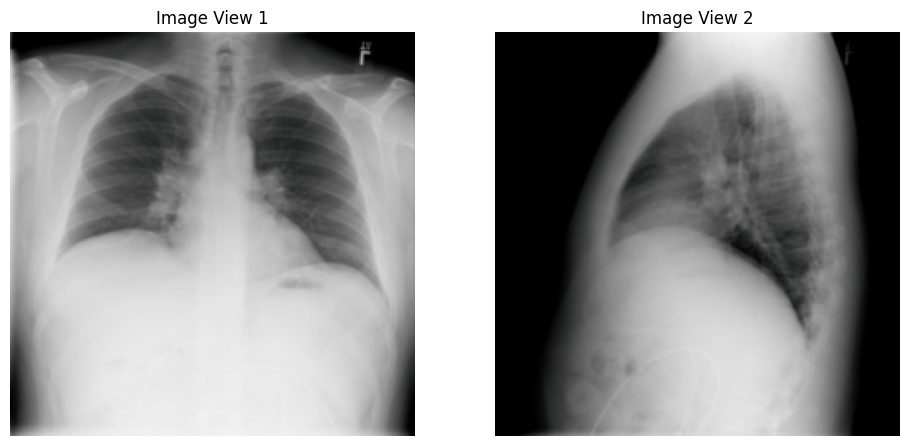


--- Sample Report from the same item (Decoded from Tensors) ---
 the examination consists of frontal and lateral radiographs of the chest. there are diminished lung volumes. right greater than left bilateral hilar and subcarinal adenopathy is again seen. the cardiac silhouette is prominent but probably artifactually large due to diminished lung volumes. no focal consolidation, pleural effusion, or pneumothorax identified. there is a deformity of the left clavicle compatible with remote .  no evidence of acute cardiopulmonary process. mediastinal and hilar adenopathy compatible with patient's known sarcoidosis. 
--------------------------------------------------


In [10]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Image Transform ---
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Create manifest for multi-view ---
full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)

# --- Data splits ---
train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)

print(f"\nData successfully split:")
print(f"Total samples: {len(full_manifest)}")
print(f"Training set:  {len(train_manifest)} samples")
print(f"Validation set: {len(val_manifest)} samples")
print(f"Test set:      {len(test_manifest)} samples")

# --- Create Datasets and DataLoaders for multi-view ---
train_dataset = IUXRayDataset(train_manifest, tokenizer, image_transform)
val_dataset = IUXRayDataset(val_manifest, tokenizer, image_transform)
test_dataset = IUXRayDataset(test_manifest, tokenizer, image_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)

print("\nPyTorch DataLoaders are ready!")
print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"View mask shape:         {sample_batch.get('view_mask', 'Not present')}")  # If view_mask is in your collate_fn

# --- Visualization of all image views for a random report in the batch ---
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (num_views, C, H, W)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(6 * num_views, 6))
for i in range(num_views):
    # Optional: If using mask, skip padded images
    if 'view_mask' in sample_batch:
        if sample_batch['view_mask'][idx_to_show][i] == 0:
            continue  # padded image, skip

    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))

    plt.subplot(1, num_views, i + 1)
    plt.imshow(img_display)
    plt.title(f"Image View {i+1}")
    plt.axis('off')
plt.show()

# --- Decode the report text from input_ids for visualization ---
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)


# **MambaVision**

In [11]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


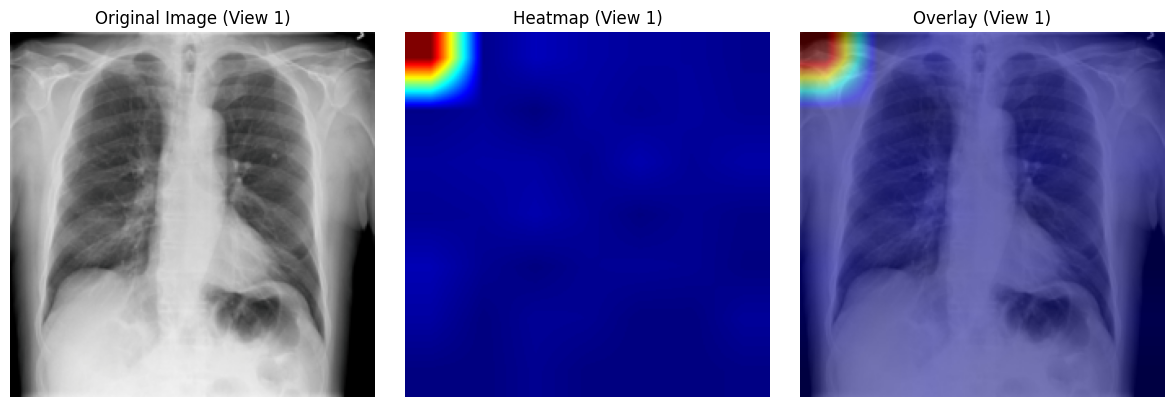

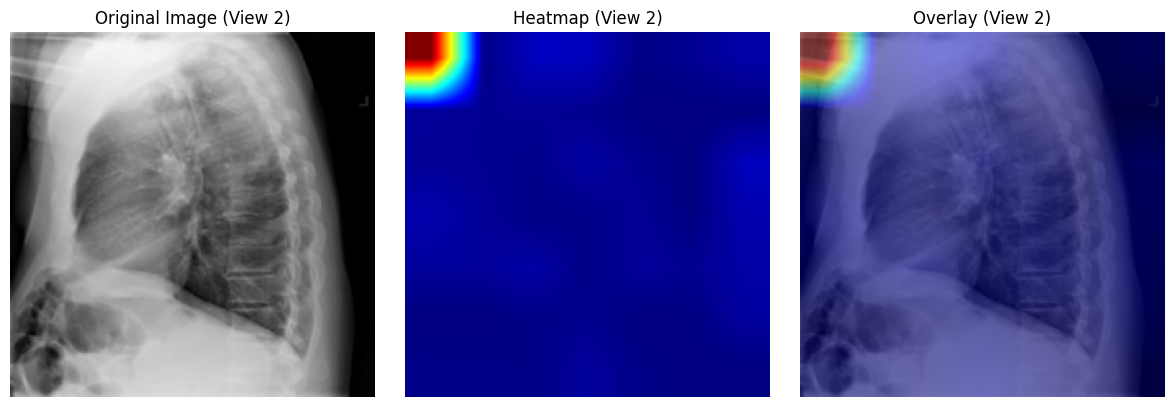

In [12]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load a batch ===
sample_batch = next(iter(train_loader))
images = sample_batch['images'].to('cuda')  # shape: (B, max_views, 3, 224, 224)

# === Forward pass (extract features for all views, all samples) ===
B, V, C, H, W = images.shape
images_flat = images.view(B * V, C, H, W)  # flatten for encoder: (B*V, 3, 224, 224)

with torch.no_grad():
    pooled_feats, stage_feats = encoder(images_flat)  # pooled_feats: (B*V, 640), stage_feats: list of (B*V, 640, 7, 7)

# --- To visualize for the idx-th item in batch, loop through its views ---
idx = 0  # select which batch sample to visualize

for view_idx in range(V):
    # Retrieve the current view's original image and feature map
    image_tensor = images[idx, view_idx].cpu()
    feature_map = stage_feats[3][idx * V + view_idx]  # select correct index in flattened batch

    # === Generate heatmap ===
    activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
    activation_map = cv2.resize(activation_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # === Unnormalize image ===
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (image_tensor * std) + mean
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
    img = np.uint8(255 * img)

    # === Overlay heatmap ===
    overlay = np.uint8(0.5 * img + 0.5 * heatmap)

    # === Display ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Heatmap (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (View {view_idx+1})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# **Projection layer**

In [13]:
import torch.nn as nn

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768):
        super().__init__()
        self.proj = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        return self.proj(vision_feat)


# **CustomGPT2**

In [14]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [15]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [17]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **Main GPT2 Block**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        
    def resize_token_embeddings(self, new_num_tokens):
        """
        Resize token embeddings and lm_head when vocabulary size changes (e.g., after adding special tokens).
        """
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
    
        if new_num_tokens == old_num_tokens:
            return self.wte
    
        # 1. New embedding layer
        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings
    
        # 2. New lm_head layer
        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head
    
        return self.wte


    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        for block in self.blocks:
            x = block(x, encoder_hidden_states)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100 # Change to your tokenizer's pad_token_id if it's not 0!
            )
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)


# **EfficientMultiViewTransformerFusion**

In [19]:
import torch
import torch.nn as nn

class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1):
        super().__init__()
        self.vision_dim = vision_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

    def forward(self, feats, view_mask=None):
        """
        Args:
            feats: (batch, num_views, vision_dim) tensor
            view_mask: (batch, num_views) tensor, 1 for valid view, 0 for padding

        Returns:
            pooled: (batch, vision_dim) tensor
        """
        # Transformer expects mask: True masks out tokens (i.e., for fake/padded views).
        key_padding_mask = None
        if view_mask is not None:
            # Transformer expects mask as bool, where True means "ignore"
            key_padding_mask = (view_mask == 0)

        # feats: (batch, num_views, vision_dim)
        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # (batch, num_views, vision_dim)

        # Masked mean pooling over the num_views axis
        if view_mask is not None:
            view_mask = view_mask.unsqueeze(-1)  # (batch, num_views, 1)
            encoded = encoded * view_mask  # mask out padded
            summed = encoded.sum(dim=1)  # sum over views
            div = view_mask.sum(dim=1)  # number of valid views per sample
            div = div.clamp(min=1)
            pooled = summed / div  # mean
        else:
            pooled = encoded.mean(dim=1)  # (batch, vision_dim) if all valid

        return pooled  # (batch, vision_dim)


# **Main Block**

In [20]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2,fusion_module):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block
        self.fusion_module = fusion_module
    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None):
        # images: (batch, max_views, C, H, W)
        B, max_views, C, H, W = images.shape
        images_flat = images.view(B * max_views, C, H, W)

        # 1. Extract visual features for all images in the batch
        pooled_feats_flat, _ = self.vision_encoder(images_flat)    # (B*max_views, vision_dim)
        vision_dim = pooled_feats_flat.shape[-1]
        pooled_feats = pooled_feats_flat.view(B, max_views, vision_dim)  # (B, max_views, vision_dim)

        # 2. Fuse features for each study
        fused_feats = self.fusion_module(pooled_feats, view_mask=view_mask)  # (B, vision_dim)

        # 3. Project
        visual_emb = self.proj_layer(fused_feats).unsqueeze(1)  # (B, 1, gpt2_emb_dim)

        # 4. Pass to decoder
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels
        )
        return outputs

    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class,fusion_module):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))
        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)
        

        return cls(vision_encoder, proj_layer, custom_gpt2,fusion_module)


# **Trainer Class**

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: your tokenizer (must have .bos_token_id and .eos_token_id)
        train_config: SimpleNamespace/args for training params (epochs, device, lr, batch_size, etc.)
        dls: tuple of (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        total_steps = len(self.train_dl)

        self.scaler = torch.cuda.amp.GradScaler()
        self.optim = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.vl_model.parameters()),
            lr=train_config.lr / 25.
        )
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=train_config.lr,
            epochs=train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.vl_model.state_dict()
        torch.save(sd, self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt')
        self.vl_model.load_state_dict(sd)
    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)


    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)
        for batch_idx, batch in enumerate(self.train_dl):
            images = batch['images'].to(self.device)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels,view_mask=view_mask)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs  # If forward returns just loss

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            self.sched.step()
            self.optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            del images, input_ids, labels, loss

        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f}")
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)
        for batch_idx, batch in enumerate(self.val_dl):
            images = batch['images'].to(self.device)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels,view_mask=view_mask)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs

            running_loss += loss.item()
            del images, input_ids, labels, loss

        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        for epoch in prog:
            # Stage-wise freezing/unfreezing
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')

            self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
            print(self.metrics.tail(1))

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
    def plot_loss_and_perplexity(self):
        """
        Plot Loss and Perplexity curves using the stored self.metrics DataFrame.
        """
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))
    
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()
    
        # Plot perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
    @staticmethod
    def clean_and_format_report(generated_report: str) -> str:
        # Replace tags with human-friendly section titles
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
    
        # Split into sections and keep only the first occurrence
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
    
        # Remove repeated lines within sections (Impression is most often repeated)
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
    
        # Nicely format the fields
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report
    @torch.no_grad()
    def robust_generate_radiology_report(
        self,
        image_input,             # file path, PIL.Image, list of paths, or list of PIL.Image
        max_tokens=120,
        temperature=1.0,
        temperature_range=None,  # e.g., (0.7, 1.1), for random temp if desired
        deterministic=False,
        show_image=False,
    ):
        """
        Generate a **structured** radiology report from one or more image inputs (multi-view).
        The generation is seeded with your custom section tokens.
        """
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device
    
        model.eval()
    
        # -- Accept list (multi-view) or single image input --
        img_list = []
        if isinstance(image_input, list):
            for img in image_input:
                if isinstance(img, (str, bytes, os.PathLike)):
                    im = Image.open(img).convert('RGB')
                elif isinstance(img, Image.Image):
                    im = img.convert('RGB')
                else:
                    raise ValueError("Each item must be a file path or PIL.Image.")
                img_list.append(im)
        else:
            # Single image path or PIL.Image
            if isinstance(image_input, (str, bytes, os.PathLike)):
                img_list = [Image.open(image_input).convert('RGB')]
            elif isinstance(image_input, Image.Image):
                img_list = [image_input.convert('RGB')]
            else:
                raise ValueError("image_input should be a file path, PIL.Image, or a list thereof.")
    
        # -- Optionally display all images --
        if show_image:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img)
                plt.title(f"Image View {i+1}")
                plt.axis('off')
            plt.show()
    
        # -- Preprocessing: transform all views identically and stack to tensor --
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        imgs_pp = [transform(img) for img in img_list]
        imgs_pp = torch.stack(imgs_pp)           # (num_views, C, H, W)
        imgs_pp = imgs_pp.unsqueeze(0).to(device) # (1, num_views, C, H, W)
    
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=device) # (batch=1, num_views) mask (all valid views)
    
        # --- Use your section start token to seed generation ---
        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
        sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
    
        # If temperature_range requested, sample probability temperature
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)
    
        for _ in range(max_tokens):
            # --- Forward through visual and fusion pipeline ---
            feats_flat, _ = model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:])) # (num_views, vision_dim)
            vision_dim = feats_flat.shape[-1]
            feats = feats_flat.view(1, num_views, vision_dim)                           # (1, num_views, vision_dim)
            fused_feats = model.fusion_module(feats, view_mask)                         # (1, vision_dim)
            visual_emb = model.proj_layer(fused_feats).unsqueeze(1)                     # (1, 1, gpt2_emb_dim)
    
            # --- Generate tokens (greedy or sampling) ---
            out = model.gpt2(
                sequence,
                encoder_hidden_states=visual_emb
            ).logits
            logits = out[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            sequence = torch.cat([sequence, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
    
        # -- Decode the generated sequence --
        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=False)
        final_report = self.clean_and_format_report(report)
        return final_report





In [22]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 25,
    freeze_epochs_gpt = 0,       # Unfreeze GPT-2 at epoch 1
    freeze_epochs_all = 0,       # Unfreeze vision encoder/proj at epoch 2
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),   # Output directory for checkpoints
    batch_size = 8
)


In [23]:

# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,      
    num_layers=3,        
    num_heads=8,        
    dropout=0.1         
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM,
    fusion_module
).to(train_config.device)

# --- Trainer ---
# Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, val_loader)  # tuple of your dataloaders
)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipykernel_19/684131347.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [24]:
trainer.fit()

  0%|          | 0/25 [00:00<?, ?it/s]

Unfreezing GPT-2 decoder...
Unfreezing vision encoder and projection...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 4.7368 | Perplexity: 114.0630


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 2.5584 | Perplexity: 12.9149
  train_loss train_perplexity  val_loss val_perplexity
0   4.736751       114.062961  2.558385      12.914947
Saving best model...


  4%|▍         | 1/25 [02:04<49:56, 124.85s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Train Loss: 2.1913 | Perplexity: 8.9471


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Valid Loss: 1.8106 | Perplexity: 6.1141
  train_loss train_perplexity  val_loss val_perplexity
1   2.191326         8.947072  1.810597       6.114098
Saving best model...


  8%|▊         | 2/25 [04:05<46:56, 122.48s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Train Loss: 1.6907 | Perplexity: 5.4232


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Valid Loss: 1.5603 | Perplexity: 4.7603
  train_loss train_perplexity  val_loss val_perplexity
2   1.690684         5.423188  1.560307       4.760281
Saving best model...


 12%|█▏        | 3/25 [06:06<44:33, 121.50s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Train Loss: 1.4427 | Perplexity: 4.2322


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Valid Loss: 1.4676 | Perplexity: 4.3387
  train_loss train_perplexity  val_loss val_perplexity
3   1.442711         4.232152  1.467579        4.33872
Saving best model...


 16%|█▌        | 4/25 [08:06<42:20, 120.97s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Train Loss: 1.2796 | Perplexity: 3.5952


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Valid Loss: 1.4502 | Perplexity: 4.2640
  train_loss train_perplexity  val_loss val_perplexity
4   1.279609         3.595234  1.450207       4.263998
Saving best model...


 20%|██        | 5/25 [10:06<40:14, 120.75s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Train Loss: 1.1700 | Perplexity: 3.2219


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Valid Loss: 1.4500 | Perplexity: 4.2630
  train_loss train_perplexity  val_loss val_perplexity
5   1.169978         3.221923  1.449964        4.26296
Saving best model...


 24%|██▍       | 6/25 [12:07<38:16, 120.89s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Train Loss: 1.0950 | Perplexity: 2.9891


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Valid Loss: 1.4632 | Perplexity: 4.3196


 28%|██▊       | 7/25 [14:05<35:56, 119.81s/it]

  train_loss train_perplexity  val_loss val_perplexity
6   1.094977         2.989114  1.463171       4.319636


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Train Loss: 0.9977 | Perplexity: 2.7121


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Valid Loss: 1.4587 | Perplexity: 4.3004


 32%|███▏      | 8/25 [16:03<33:46, 119.21s/it]

  train_loss train_perplexity  val_loss val_perplexity
7   0.997717         2.712084  1.458699       4.300359


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Train Loss: 0.8818 | Perplexity: 2.4152


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Valid Loss: 1.4709 | Perplexity: 4.3531


 36%|███▌      | 9/25 [18:01<31:42, 118.91s/it]

  train_loss train_perplexity  val_loss val_perplexity
8   0.881764         2.415157  1.470883       4.353077


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Train Loss: 0.7509 | Perplexity: 2.1190


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Valid Loss: 1.4725 | Perplexity: 4.3602


 40%|████      | 10/25 [19:59<29:37, 118.50s/it]

  train_loss train_perplexity  val_loss val_perplexity
9   0.750928         2.118965  1.472524       4.360227


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Train Loss: 0.6258 | Perplexity: 1.8697


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Valid Loss: 1.5368 | Perplexity: 4.6495


 44%|████▍     | 11/25 [21:56<27:36, 118.32s/it]

   train_loss train_perplexity  val_loss val_perplexity
10   0.625802         1.869746  1.536754       4.649475


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Train Loss: 0.5115 | Perplexity: 1.6678


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Valid Loss: 1.5643 | Perplexity: 4.7794


 48%|████▊     | 12/25 [23:54<25:35, 118.08s/it]

   train_loss train_perplexity  val_loss val_perplexity
11   0.511528         1.667838  1.564315       4.779399


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Train Loss: 0.3963 | Perplexity: 1.4863


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Valid Loss: 1.6184 | Perplexity: 5.0450


 52%|█████▏    | 13/25 [25:52<23:35, 117.99s/it]

   train_loss train_perplexity  val_loss val_perplexity
12   0.396271         1.486272  1.618406       5.045043


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Train Loss: 0.3177 | Perplexity: 1.3739


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Valid Loss: 1.6631 | Perplexity: 5.2759


 56%|█████▌    | 14/25 [27:50<21:37, 117.96s/it]

   train_loss train_perplexity  val_loss val_perplexity
13   0.317651         1.373897  1.663141       5.275854


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Train Loss: 0.2638 | Perplexity: 1.3018


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Valid Loss: 1.7155 | Perplexity: 5.5596


 60%|██████    | 15/25 [29:47<19:37, 117.79s/it]

   train_loss train_perplexity  val_loss val_perplexity
14    0.26377         1.301828  1.715532       5.559635


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Train Loss: 0.2252 | Perplexity: 1.2526


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Valid Loss: 1.7397 | Perplexity: 5.6957


 64%|██████▍   | 16/25 [31:44<17:38, 117.57s/it]

   train_loss train_perplexity val_loss val_perplexity
15   0.225209         1.252585  1.73971       5.695692


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Train Loss: 0.1993 | Perplexity: 1.2205


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Valid Loss: 1.7802 | Perplexity: 5.9310


 68%|██████▊   | 17/25 [33:42<15:42, 117.80s/it]

   train_loss train_perplexity  val_loss val_perplexity
16   0.199255         1.220493  1.780189       5.930977


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Train Loss: 0.1792 | Perplexity: 1.1963


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Valid Loss: 1.7955 | Perplexity: 6.0228


 72%|███████▏  | 18/25 [35:40<13:44, 117.79s/it]

   train_loss train_perplexity  val_loss val_perplexity
17   0.179194         1.196253  1.795548       6.022776


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Train Loss: 0.1653 | Perplexity: 1.1797


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Valid Loss: 1.8208 | Perplexity: 6.1766


 76%|███████▌  | 19/25 [37:38<11:46, 117.68s/it]

   train_loss train_perplexity  val_loss val_perplexity
18     0.1653         1.179747  1.820765       6.176584


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Train Loss: 0.1556 | Perplexity: 1.1684


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Valid Loss: 1.8318 | Perplexity: 6.2453


 80%|████████  | 20/25 [39:35<09:48, 117.69s/it]

   train_loss train_perplexity  val_loss val_perplexity
19   0.155617         1.168379  1.831822       6.245257


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Train Loss: 0.1464 | Perplexity: 1.1576


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Valid Loss: 1.8591 | Perplexity: 6.4181


 84%|████████▍ | 21/25 [41:33<07:50, 117.67s/it]

   train_loss train_perplexity  val_loss val_perplexity
20   0.146384         1.157641  1.859117       6.418068


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Train Loss: 0.1407 | Perplexity: 1.1510


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Valid Loss: 1.8627 | Perplexity: 6.4409


 88%|████████▊ | 22/25 [43:31<05:52, 117.66s/it]

   train_loss train_perplexity  val_loss val_perplexity
21   0.140665         1.151039  1.862674       6.440935


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Train Loss: 0.1349 | Perplexity: 1.1445


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Valid Loss: 1.8775 | Perplexity: 6.5371


 92%|█████████▏| 23/25 [45:29<03:55, 117.74s/it]

   train_loss train_perplexity  val_loss val_perplexity
22   0.134932          1.14446  1.877496       6.537113


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Train Loss: 0.1306 | Perplexity: 1.1395


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Valid Loss: 1.8865 | Perplexity: 6.5962


 96%|█████████▌| 24/25 [47:26<01:57, 117.77s/it]

   train_loss train_perplexity  val_loss val_perplexity
23   0.130585         1.139495  1.886486       6.596152


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Train Loss: 0.1279 | Perplexity: 1.1364


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/684131347.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Valid Loss: 1.8896 | Perplexity: 6.6166


100%|██████████| 25/25 [49:24<00:00, 118.59s/it]

   train_loss train_perplexity  val_loss val_perplexity
24   0.127891          1.13643  1.889579       6.616585


{'best_perplexity': 4.262960486960586, 'best_epoch': 5}

# **Loading Trained Model**

In [25]:
trainer.load_best_model()

In [26]:
#trainer.load_model_from_path("/kaggle/input/mambavisionv1/vl_model-2.pt")

# **Report Genearation**

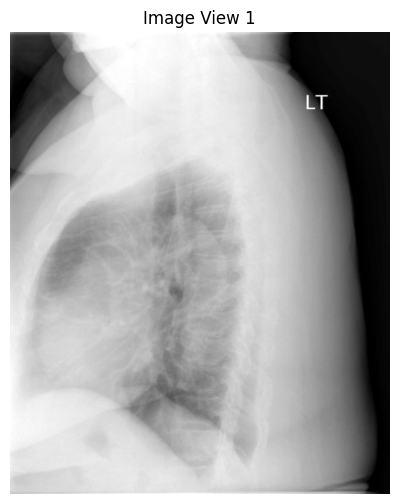

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Generated report: Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.


In [27]:
report = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1013_IM-0013-2001.png"],
    max_tokens=100,
    temperature_range=(0.5, 1.5),
    deterministic=True,
    show_image=True
)
print("Generated report:", report)

In [28]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [29]:
from torch.utils.data import ConcatDataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths_list = batch['image_paths']  # <- list of lists: one per sample

        for i in range(len(image_paths_list)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # --- Load all image views for this report ---
            pil_imgs = []
            for image_path in image_paths_list[i]:
                pil_img = Image.open(image_path).convert('RGB')
                pil_imgs.append(pil_img)
            # --- Generate report from all images for this study ---
            gen_report = trainer.robust_generate_radiology_report(
                pil_imgs,    # passing list of PIL images for multi-view support
                deterministic=True
            )
            
            
            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)
            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)


            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


Evaluating dataset: 100%|██████████| 24/24 [38:21<00:00, 95.88s/it]

       BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L
0    0.019452  0.007504  0.002100  0.001076  0.088491  0.155172
1    0.229245  0.088433  0.031323  0.017941  0.162574  0.139535
2    0.480000  0.316228  0.238825  0.185567  0.353850  0.205128
3    0.320000  0.200000  0.154401  0.112133  0.650773  0.400000
4    0.445524  0.355464  0.289841  0.240517  0.445419  0.520000
..        ...       ...       ...       ...       ...       ...
378  0.222911  0.097010  0.028283  0.014781  0.170416  0.222222
379  0.272082  0.092564  0.031415  0.017635  0.186566  0.136364
380  0.099179  0.008265  0.003804  0.002464  0.122137  0.170732
381  0.041138  0.021682  0.014324  0.009667  0.104364  0.156863
382  0.480000  0.316228  0.238825  0.185567  0.382412  0.270270

[383 rows x 6 columns]
Average Scores: {'BLEU-1': 0.2637308752976745, 'BLEU-2': 0.14373603708833635, 'BLEU-3': 0.08952650291436283, 'BLEU-4': 0.06470417309311044, 'METEOR': 0.23326490513889322, 'ROUGE-L': 0.2599307202244007}


In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_imgs,
            max_tokens=100,
            temperature_range=(0.5, 1.5),
            deterministic=True,
            show_image=False  # we already plotted images here
        )

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)


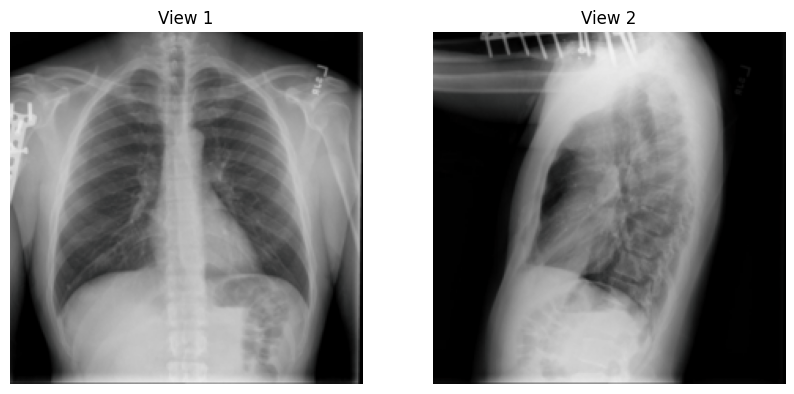


--- Ground Truth Report ---
there are scattered calcified granulomas. the lungs are otherwise clear. no focal airspace consolidation. no pleural effusion or pneumothorax. normal heart size and mediastinal contour. right humeral internal fixation is noted.  no evidence of active disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


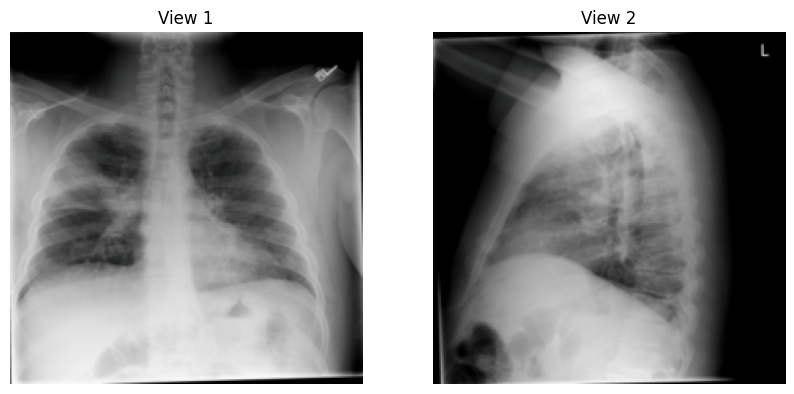


--- Ground Truth Report ---
frontal and lateral views of the chest show an unchanged cardiomediastinal silhouette. there is airspace opacity in the mid right lung radiating from the right hilum to the pleura and bordered inferiorly by the fissures. the fissure is convex upward. there is right base patchy airspace opacity. this appears chronic and may be due to scarring. there is no significant pleural effusion.  right upper lobe airspace consolidation please correlate clinically for pneumonia.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


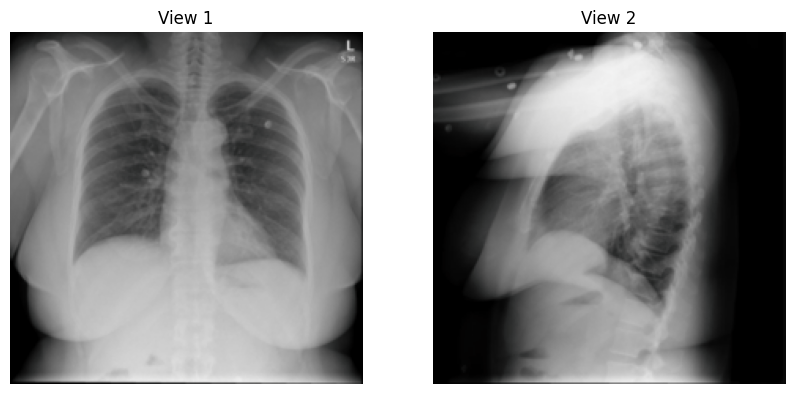


--- Ground Truth Report ---
normal heart size. no focal air space consolidation, pneumothorax, pleural effusion, or pulmonary edema. anterior osteophytes of the thoracic spine.  no acute cardiopulmonary disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


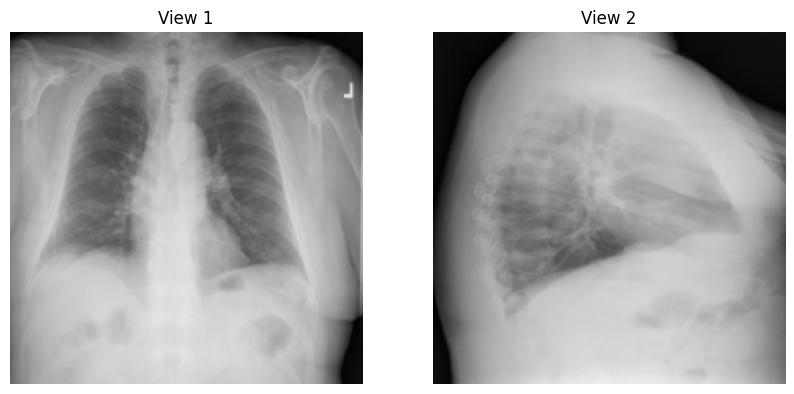


--- Ground Truth Report ---
the heart, pulmonary and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pneumonia. there are degenerative changes of the thoracic spine. there is a calcified granuloma identified in the right suprahilar region. the aorta is mildly tortuous and ectatic. there is asymmetric right apical smooth pleural thickening. there are severe degenerative changes of the .  no acute cardiopulmonary disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


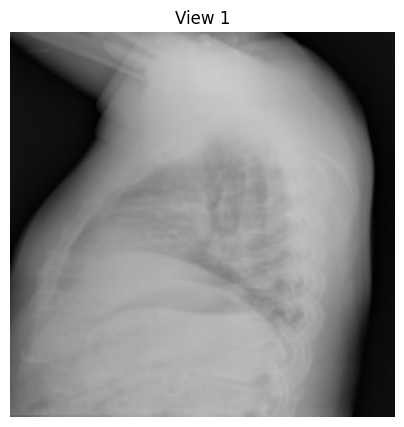


--- Ground Truth Report ---
the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality.  no acute cardiopulmonary abnormality..

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


In [31]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)

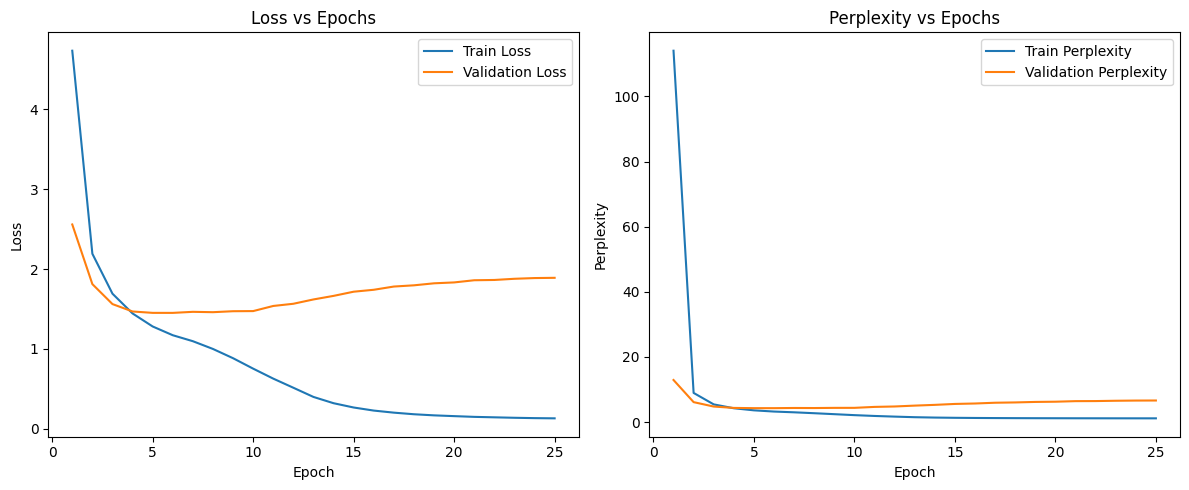

In [32]:
trainer.plot_loss_and_perplexity()